#### Test RS knn with cosine distance on mean centered data, evaluating with RSME and MAE

In [47]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# import DB et set min_reviews
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", names=["Username", "User id"])

min_reviews = 5

In [49]:
# filter data with the minimum reviews
filtered_data = filter_df(avis_clean, min_reviews)

# we center the ratings for the centered cos version
filtered_centrd_data, avg_df = center_score(filtered_data)

11201 10549
3242 3957
3006 3910
3003 3910


In [50]:
# get the needed matrixes

# matrix_ratings : sparse matrix for nonzero values only: row = users, cols = games
# mask_ratings : mask for NaN values only -> with matrix_ratings, can get ratings = 0
# users/games_table_assoc : association index - ids for the matrix_use

matrix_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_centrd_data)
matrix_ratings_n, mask_ratings_n, users_table_assoc_n, games_table_assoc_n = get_matrix_user_game(filtered_data)
users_table_assoc

0           0
1           1
2           2
3           3
4           4
        ...  
2998    10628
2999    10685
3000    10686
3001    10713
3002    10775
Name: User id, Length: 3003, dtype: int64

In [51]:
# we calculate the similarity matrix with cos on the centered values
similarity_matrix, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
similarity_matrix_n, _ = calc_similarity_matrix(matrix_ratings_n, mask_ratings_n, "cos")

# cosine similarity range [-1,1] cosine distance = 1 - similarity, range [0, 2] 

In [52]:
# for the evaluation, we test on the X most popular users (by number of reviews) 
NB_USERS = 200
users_count = filtered_centrd_data[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values(by="Game id", ascending=False).head(NB_USERS)

# get the index (matrix) associated to the selected users ids
users = users_table_assoc[users_table_assoc.isin(users_count.index)].index.to_numpy()
type(users)

numpy.ndarray

#### **RMSE** 

In [10]:
result = np.load("generated_data/rmse_centered_200_cos.npy")

In [53]:
# calculate rmse DO NOT RUN CELL
vect_rmse = np.vectorize(calc_RMSE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
result = vect_rmse(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix)
np.save(f"generated_data/rmse_centered_{NB_USERS}_cos.npy", result)

In [54]:
# rsme calculated for each users, RMSE can be above 10
np.unique(result)

array([1.11241791, 1.24715448, 1.28804008, 1.43169845, 1.48565522,
       1.50730656, 1.50744451, 1.51201933, 1.52334593, 1.52716056,
       1.53118481, 1.5629031 , 1.57258004, 1.57554185, 1.58334549,
       1.58853702, 1.5966601 , 1.59916101, 1.60157632, 1.60382964,
       1.61209964, 1.61889219, 1.62520335, 1.62764615, 1.63061411,
       1.64970426, 1.65073845, 1.66553797, 1.675565  , 1.67940713,
       1.68473729, 1.69926299, 1.70447925, 1.70454567, 1.71850265,
       1.72219904, 1.72716894, 1.73303811, 1.74928499, 1.75810298,
       1.7581125 , 1.75846229, 1.76271704, 1.77121723, 1.78703086,
       1.79030455, 1.79309024, 1.79548613, 1.79744091, 1.80254893,
       1.80386174, 1.80552467, 1.81505781, 1.8155612 , 1.81740589,
       1.82746177, 1.83803919, 1.84098608, 1.8411289 , 1.84495343,
       1.84522507, 1.84930129, 1.86071738, 1.86815517, 1.87080788,
       1.87253687, 1.87835121, 1.8852241 , 1.89434823, 1.89894654,
       1.89925404, 1.90000979, 1.90143454, 1.90510401, 1.90672

In [55]:
# users_table_assoc[users] = true id of users
# we associate each users with their RMSE and count reviews
rmse_users = pd.DataFrame(zip(users_table_assoc[users], result), columns=["User id", "RMSE"]).merge(users_count, on ="User id")
rmse_users.columns = ["User id", "RMSE", "Count reviews"]
rmse_users.sort_values(by="Count reviews", inplace=True)
rmse_users

,User id,RMSE,Count reviews
133,1919,1.627646,128
86,1195,1.507307,128
165,2282,2.572198,129
154,2246,2.178475,129
41,364,2.074404,129
...,...,...,...
33,201,1.718503,702
11,91,2.097933,764
8,83,2.066384,921
0,1,1.431698,970


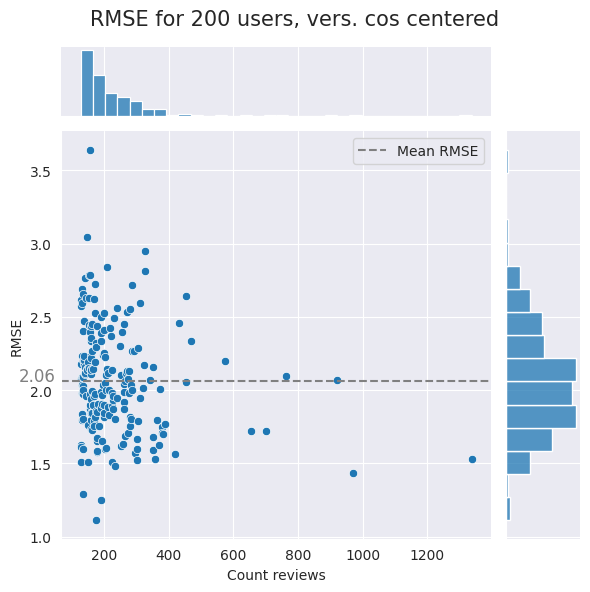

In [56]:
# we plot the RMSE distribution for cos

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="RMSE", kind="scatter")
plot.ax_joint.axhline(rmse_users["RMSE"].mean(), color="gray", linestyle="--", label="Mean RMSE")
plot.ax_joint.text(x=50, y=rmse_users["RMSE"].mean(), s=f'{round(rmse_users["RMSE"].mean(), 2)}', color='gray', fontsize=12, ha='right')
plot.figure.suptitle(f'RMSE for {NB_USERS} users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()

plt.savefig('images/rmse_centered_min5_200_user_cos.png')

In [57]:
# normalized RMSE 
rmse_users['Normalized RMSE'] = (rmse_users['RMSE'] - rmse_users['RMSE'].min()) / (rmse_users['RMSE'].max() - rmse_users['RMSE'].min())
rmse_users

,User id,RMSE,Count reviews,Normalized RMSE
133,1919,1.627646,128,0.203927
86,1195,1.507307,128,0.156297
165,2282,2.572198,129,0.577781
154,2246,2.178475,129,0.421946
41,364,2.074404,129,0.380754
...,...,...,...,...
33,201,1.718503,702,0.239888
11,91,2.097933,764,0.390067
8,83,2.066384,921,0.377580
0,1,1.431698,970,0.126371


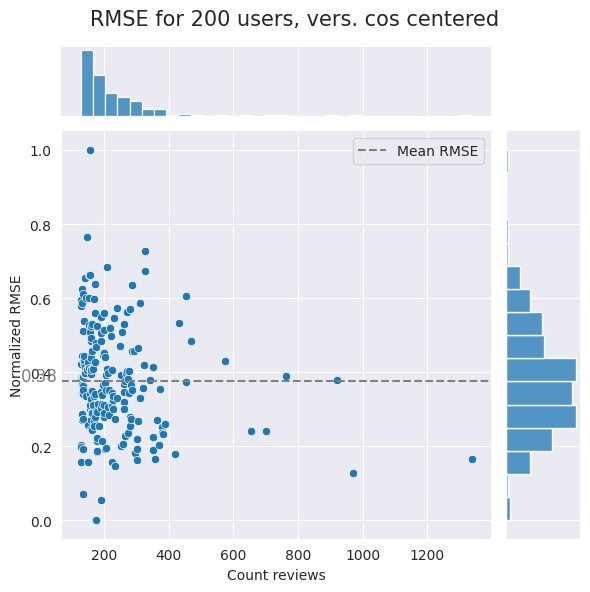

In [58]:
# we plot the RMSE normalized distribution

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="Normalized RMSE", kind="scatter")
plot.ax_joint.axhline(rmse_users["Normalized RMSE"].mean(), color="gray", linestyle="--", label="Mean RMSE")
plot.ax_joint.text(x=0, y=rmse_users["Normalized RMSE"].mean(), s=f'{round(rmse_users["Normalized RMSE"].mean(), 2)}', color='gray', fontsize=12, ha='center')
plot.figure.suptitle(f'RMSE for {NB_USERS} users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()
plt.savefig("images/rmse_centrd_min5_200_users_cos.png")

#### **MAE**

In [43]:
result = np.load("generated_data/mae_centered_200_cos.npy")

In [59]:
# calculate mae DO NOT RUN CELL
vect_mae = np.vectorize(calc_MAE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
result = vect_mae(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix)
np.save(f"generated_data/mae_centered_{NB_USERS}_cos.npy", result)

In [60]:
# users_table_assoc[users] = true id of users
# we associate each users with their MAE and count reviews
rmse_users = pd.DataFrame(zip(users_table_assoc[users], result), columns=["User id", "MAE"]).merge(users_count, on ="User id")
rmse_users.columns = ["User id", "MAE", "Count reviews"]
rmse_users.sort_values(by="Count reviews", inplace=True)
# normalized MAE 
rmse_users['Normalized MAE'] = (rmse_users['MAE'] - rmse_users['MAE'].min()) / (rmse_users['MAE'].max() - rmse_users['MAE'].min())
rmse_users

,User id,MAE,Count reviews,Normalized MAE
133,1919,1.609397,128,0.302175
86,1195,1.479862,128,0.249136
165,2282,1.232174,129,0.147717
154,2246,1.619176,129,0.306179
41,364,1.660355,129,0.323041
...,...,...,...,...
33,201,1.483507,702,0.250628
11,91,1.549307,764,0.277571
8,83,1.603831,921,0.299896
0,1,1.263920,970,0.160716


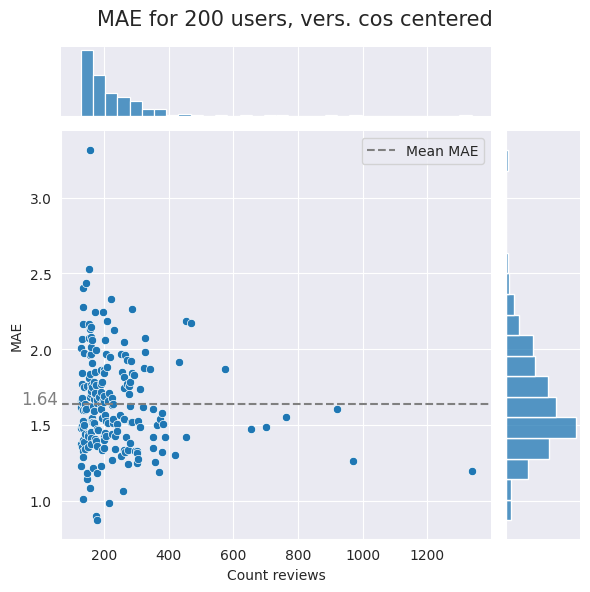

In [61]:
# we plot the MAE distribution

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="MAE", kind="scatter")
plot.ax_joint.axhline(rmse_users["MAE"].mean(), color="gray", linestyle="--", label="Mean MAE")
plot.ax_joint.text(x=0, y=rmse_users["MAE"].mean(), s=f'{round(rmse_users["MAE"].mean(), 2)}', color='gray', fontsize=12, ha='center')
plot.figure.suptitle(f'MAE for {NB_USERS} users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()

plt.savefig("images/mae_centrd_min5_200_cos")